### About Mercado Livre

  O Mercado Livre é um dos maiores market place e fintech da América Latina. Uma empresa pioneira no comércio eletrônico, baseada em uma plataforma onde os usuários compram, vendem, anunciam, enviam, financiam e pagam bens e serviços através da Internet.

### The Challenge

  No MercadoLivre existem milhões de publicações de produtos e serviços. Ter dados estruturados descrevendo cada uma é um fator-chave para fornecer a melhor experiência ao cliente, facilitando a pesquisa e descoberta de produtos, melhorando as recomendações, fornecendo planilhas de dados técnicos integrais, estimativas de tamanhos de pacotes, entre outros.
  É por isso que é vital garantir que cada publicação esteja adequadamente classificada (se é um celular, um refrigerador, uma televisão, etc.). No entanto, dada a variedade de produtos e as milhares de categorias disponíveis, escolher a categoria certa pode ser uma tarefa difícil.

### The project
  O projeto consiste em classificar o produto conforme a categoria, isso a partir do título do anúncio o qual é forcecido pelo anunciante/vendedor.
  

### Data Used

  O arquivo de treinamento corresponde a 20 milhões de publicações, contendo quatro colunas com as seguintes informações:
  - **Title**: O título da publicação;
  - **Language**: O idioma do título, pode ser português e espanhol;
  - **Label quality**: Pode ser confiável ou não confiável. As linhas confiáveis foram revisadas pela equipe do Mercado livre. As linhas marcadas como não confiáveis não foram revisadas, o que significa que a categoria foi escolhida pelo vendedor e, portanto, deve ser esperada uma taxa mais alta de erros de rotulagem.
  - **Category (variable target)**: A categoria da publicação. O conjunto de categorias serve para os dois idiomas.


  O arquivo de teste possui 246955 publicações com as colunas de title, language e id, que referencia a publicação no momento da submissão no portal do desafio. 

### Preprocessing

A primeira coisa que faremos é pré-processar os dados do título para que sejam mais fáceis de lidar e prontos para a extração de recursos e o treinamento dos classificadores.

Para começar, vamos fazer o download do arquivos e converter em Dataframes.

Em seguida, para o pré-processamento, iremos:
  - Converter a coluna title para lowercase;
  - Segmentar cada title em palavras usando um segmentador NTLK;
  - Remover palavras que são inúteis ao classificador;
  - Tokenizar os títulos usando um tokenizer NLTK;
  - 


Vamos criar algumas funções para realizar tudo isso.

First import a lot of librarys.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
import time

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adagrad, RMSprop
import keras.backend as K

import re
import random
import string

Using TensorFlow backend.


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('rslp')
#Word Stemmer
from nltk.stem import RSLPStemmer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [3]:
#For remove accents
!pip install unidecode
import unidecode

     |████████████████████████████████| 245kB 6.4MB/s 


### Download Dataset from Oficial Page

Em virtude do tamanho do Dataset de treino e test, irei efetuar o download direto da página oficial do desafio.

In [0]:
from urllib.request import urlretrieve
def download(url, file):
  if not os.path.isfile(file):
    print("Download file ... "+ file + "...")
    urlretrieve(url,file)
    print("Download completed . . .")

In [5]:
download('https://meli-data-challenge.s3.amazonaws.com/train.csv.gz', 'train.csv.gz')
download('https://meli-data-challenge.s3.amazonaws.com/test.csv', 'test.csv')
download('https://meli-data-challenge.s3.amazonaws.com/sample_submission.csv', 'sample_submission.csv')
print('Files downloaded . . .')

Download file ... train.csv.gz...
Download completed . . .
Download file ... test.csv...
Download completed . . .
Download file ... sample_submission.csv...
Download completed . . .
Files downloaded . . .


### Read Datasets

Leitura dos arquivos e conversão da coluna título para lower case.

In [0]:
train = pd.read_csv("train.csv.gz")
test = pd.read_csv("test.csv")
#sample_sub = pd.read_csv("sample_submission.csv")

#Convert column title to lower case in both datasets
train['title'] = train["title"].map(lambda x: x.lower())

test['title'] = test["title"].map(lambda x: x.lower())

In [7]:
train.shape

(20000000, 4)

In [8]:
train.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba a...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,placa de sonido - behringer umc22,unreliable,spanish,SOUND_CARDS
2,maquina de lavar electrolux 12 kilos,unreliable,portuguese,WASHING_MACHINES
3,par disco de freio diant vent gol 8v 08/ frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,flashes led pestañas luminoso falso pestañas p...,unreliable,spanish,FALSE_EYELASHES


In [9]:
test.shape

(246955, 3)

In [10]:
test.head()

,id,title,language
0,0,kit maternidade bolsa-mala baby/bebe vinho men...,portuguese
1,1,trocador de fraldas fisher price feminino rosa...,portuguese
2,2,motor ventoinha - fiat idea / palio 1.8 - a 04...,portuguese
3,3,amortecedor mola batente d dir new civic 14 - ...,portuguese
4,4,cadeirinha de carro bebê princesa princess 9 a...,portuguese


A partir desse ponto temos ideia do tamanho do conjunto de dados e os desafios que enfrentaremos para o treinamento. 

### Modelagem de Dados


Analisando o gráfico a seguir, percebe-se que o tamanho do título obedece uma distribuição Gaussiana. A modelagem parte do pressuposto que o título com até 5 palavras contém informação suficiente para classificar corretamente a publicação. Dessa forma, o título possui palavras que não são úteis na classificação e precisam ser removidas. Isso ajuda no tempo de treinamento e na acurácia do modelo. 



Text(0.5, 0, 'Count of Words')

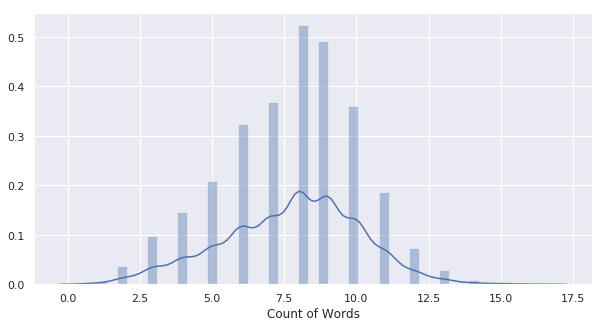

In [51]:
wordsCount = train.head(5000)['title'].apply(lambda li: len(li.split()))

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(wordsCount)
plt.xlabel('Count of Words')

### Function Remove StopWords and Ponctuation

  Esta função efetua o tratamento das palavras que compõem o título, a fim de evitar palavras de mesmo sentido duplicadas, e remoção daquelas que não são uteis para a classificação. Foram excluídos alguns termos chave que são recorrentes em produtos de diversas categorias como "frete grátis" e adjetivos, além de palavras que contém digitos, pontuação e Stop Words. 
   Nesse processo foram utilizadas algumas técnicas (Word Stemmer e Lemmatization com as bibliotecas NLTK e Spacy) para manter apenas o núcleo principal do título do anúncio e reduzir o ruído existente, porém não representaram melhora significativa na performance do classificador, por isso estão comentadas as linhas.

In [0]:
#Word Stemmer
#portugueseStemmer = SnowballStemmer("portuguese")
#stemmer = RSLPStemmer()

#Remove Ponctuation and Numbers
removeChar = string.punctuation

notUseful = ['kit', 'frete', 'envio', 'gratis', 'pronta', 'entrega', 'nova', 
             'usado', 'usada','novo', 'original', 'cm', 'mm', 'promocao', 
             'combo', 'kg', 'nuevo', 'cm', 'mini', 'oferta', 'litros', 'negro',
             'set', 'par', 'promocao', 'pack', 'kg', 'completo', 'profissional',
             'black', 'grande', 'nuevo', 'nueva', 'tipo', 'ml', 'metros', 
             'universal', 'bivolt', 'new', 'pcs', 'completa', 'red', 'ano', 
             'ii', 'branco', 'branca', 'preto', 'preta', 'azul', 'vermelho', 
             'vermelha', 'rosa', 'verde', 'amarelo']

stopWordsData = stopwords.words('spanish') + stopwords.words('portuguese') + list(string.ascii_lowercase) + notUseful


def removeStopLine(line):
    #Remove accents
    text = unidecode.unidecode(line)
    #Replace "./-" for espace
    text = text.translate(str.maketrans(',./-', '    '))
    #Remove ponctuation
    text = text.translate(str.maketrans('', '', removeChar))
    listWords = text.split()
    #listWords = nlp(text)

    #Remove StopWords and Numbers
    #text = [portugueseStemmer.stem(word) for word in listWords if (word not in stopWordsData and not(word.isdigit()))]
    #text = [word.lemma_ for word in listWords if (word.lemma_ not in stopWordsData and not(re.search('\d+', word.lemma_)))]
    text = [word for word in listWords if (word not in stopWordsData and not(re.search('\d+', word)))]
    text = ' '.join(text)
    return text

Após a remoção de StopWords verifica se a coluna de título ficou vazia e insere um dado para identificar.

In [0]:
#Drop row if length title is zero
def indexesZeroTrain(data):
    indexes = data[data['title_nopunc'].apply(len) == 0].index
    print(len(indexes))
    data.drop(indexes, inplace=True)
    #print(data['title'][indexes])
    #data['title_nopunc'][indexes] = 'nothing'
    return data

#Set to 'nothing' title if length is zero
def indexesZeroTest(data):
    indexes = data[data['title_nopunc'].apply(len) == 0].index
    print(len(indexes))
    data['title'][indexes] = 'nothing'
    data['title_nopunc'][indexes] = 'nothing'
    return data

### Split in Realiable Dataset

Divisão do dataset de treino com base nos dados verificados. Além de todos os dados verificados são utilizados outra parcela de dados não verificados, pois nem todas as categorias possuem dados verificados.

In [14]:
trainReliable = train[train['label_quality'] == 'reliable']
trainUnreliable = train[train['label_quality'] == 'unreliable']

print("Reliable: ", trainReliable.shape, 'Unrealible: ', trainUnreliable.shape)
trainReliable.drop('label_quality', axis=1, inplace=True)
#trainReliable.describe()

_, trainUnreliable = train_test_split(trainUnreliable, test_size=0.07, random_state=42, stratify=trainUnreliable.category)

trainReliable = trainReliable.append(trainUnreliable)

trainReliable.shape

Reliable:  (1184245, 4) Unrealible:  (18815755, 4)


(2501348, 4)

### Train - Remove StopWords

Cria uma nova coluna no dataset de treino com a feature título sem as StopWords.

In [15]:
#trainData = train.head(1000000)
init = time.time()

trainReliable['title_nopunc'] = trainReliable['title'].apply(removeStopLine)

print('Time to processed: ', time.time() - init)

trainReliable = indexesZeroTrain(trainReliable)

Time to processed:  193.4474275112152
717


In [18]:
trainReliable.head()

,category,label_quality,language,title,title_nopunc
16,AIR_COMPRESSORS,NaN,portuguese,projeto unidade hidraulica 3000 psi,projeto unidade hidraulica psi
25,CARPETS,NaN,portuguese,tapete capacho 120x60 churrasqueira + frete gr...,tapete capacho churrasqueira
57,T_SHIRTS,NaN,portuguese,camiseta raglan crepúsculo jealous baby look,camiseta raglan crepusculo jealous baby look
82,DVD_RECORDERS,NaN,portuguese,unidade de dvd gravador com defeito apenas par...,unidade dvd gravador defeito apenas pecas
99,DESKTOP_COMPUTER_COOLERS_AND_FANS,NaN,portuguese,fan dell r320 / r420 0hr6c0 - 24h,fan dell


### Test - Remove StopWords

Executa o mesmo processo aplicado ao dados de treino para remoção de StopWords. Além disso, remove a coluna id para auxiliar na concatenação dos dataframes. 

In [16]:
init = time.time()

test["title_nopunc"] = test['title'].apply(removeStopLine)

print('Time to processed: ', time.time() - init)

test = indexesZeroTest(test)

test.drop('id', axis=1, inplace=True)

Time to processed:  19.048086643218994
24


In [17]:
test.head()

,title,language,title_nopunc
0,kit maternidade bolsa-mala baby/bebe vinho men...,portuguese,maternidade bolsa mala baby bebe vinho menina
1,trocador de fraldas fisher price feminino rosa...,portuguese,trocador fraldas fisher price feminino portatil
2,motor ventoinha - fiat idea / palio 1.8 - a 04...,portuguese,motor ventoinha fiat idea palio
3,amortecedor mola batente d dir new civic 14 - ...,portuguese,amortecedor mola batente dir civic
4,cadeirinha de carro bebê princesa princess 9 a...,portuguese,cadeirinha carro bebe princesa princess kgs


### Word Embeeding

  - A sequência a seguir concatena os dataframes de treino e test a fim de que o algoritmo de treinamento esteva familiarizado com o conteúdo do dataset de test. 
  - Define o tamanho do vocabulário com as palavras mais importantes, classificadas pelo Keras Tokenizer
  - Verifica se alguma linha ficou vazia e adiciona o title tratado para não perder aquele registro.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
sizeTrain = trainReliable.shape[0]
sizeTest = test.shape[0]

In [0]:
trainReliable = trainReliable.append(test)

In [22]:
tokenizer = Tokenizer(num_words=20000)

init = time.time()

tokenizer.fit_on_texts(trainReliable['title_nopunc'])
X_train = tokenizer.texts_to_sequences(trainReliable['title_nopunc'])

#maxlen = 5

#X_train = pad_sequences(X_train, truncating='post',maxlen=maxlen)
#X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train = tokenizer.sequences_to_texts(X_train)

#from operator import itemgetter
#sortedWords = sorted(tokenizer.word_counts.items(), key=itemgetter(1), reverse = True)

print('Processing time Tokenizer: ', int(time.time() - init), ' segundos')

Time to processed Tokenizer:  88  segundos


In [25]:
vl = 1586930
print('Example before: ', trainReliable['title_nopunc'].iloc[vl])
print('After: ',X_train[vl])

Example before:  engranaje tercera arbol primario volkano motomel
After:  engranaje tercera arbol primario motomel


A partir desse ponto os dataset estão com as palavras mais importante e serão convertidos na matriz para treinamento. 

In [26]:
trainReliable['title_nopunc'] = X_train
test = trainReliable.tail(sizeTest)
trainReliable = trainReliable.head(sizeTrain)

print('Size Train: ', trainReliable.shape , 'Size Test: ',test.shape)

Size Train:  (2500631, 5) Size Test:  (246955, 5)


In [0]:
indexes = trainReliable[trainReliable['title_nopunc'].apply(len) == 0].index
trainReliable['title_nopunc'][indexes] = trainReliable.loc[indexes]['title'].apply(removeStopLine)

indexes = test[test['title_nopunc'].apply(len) == 0].index
test['title_nopunc'][indexes] = test.loc[indexes]['title'].apply(removeStopLine)

### Split Datasets by Languages

  - As duas linguages não possuem tanta semelhança, assim serão treinadas separamente o que garante uma melhor performance do algoritmo. 

In [0]:
trainPortuguese = trainReliable[trainReliable['language'] == 'portuguese']
trainSpanish = trainReliable[trainReliable['language'] == 'spanish']

In [0]:
i = trainPortuguese[trainPortuguese['category'] == 'PACKAGING_CONTAINERS'].index
ii = trainPortuguese[trainPortuguese['category'] == 'FIELD_HOCKEY_STICKS'].index
trainPortuguese.drop(i, inplace=True)
trainPortuguese.drop(ii, inplace=True)

In [0]:
ix = trainSpanish[trainSpanish['category'] == 'CHESS_CLOCKS'].index
trainSpanish.drop(ix, inplace=True)

In [31]:
trainPortuguese['category'].value_counts().tail()

POOL_PAINTS                 4
BOXING_SPEED_BAGS           4
COFFEE_VENDING_MACHINES     3
WAKEBOARD_BOOTS             2
MARTIAL_ARTS_FOOT_GUARDS    2
Name: category, dtype: int64

In [0]:
testPortuguese = test[test['language'] == 'portuguese']
testSpanish = test[test['language'] == 'spanish']

### Resize Dataset by defined size

  - Como o conjunto de treino é muito grande, a função retorna um dataframe menor utilizando Sklean train_test_split com o parâmetro Stratify para manter a proporção de categorias nos dados de treino. 

In [0]:
def resizeDataset( size, language):
    if (language == 'portuguese'):
        testSize = size / trainPortuguese.shape[0]
        _, X_test = train_test_split(trainPortuguese, test_size=testSize, random_state=101, stratify=trainPortuguese.category)
        return X_test
    elif (language == 'spanish' ):
        testSize = size / trainSpanish.shape[0]
        _, X_test = train_test_split(trainSpanish, test_size=testSize, random_state=101, stratify=trainSpanish.category)
        return X_test
    else:
        testSize = size / train.shape[0]
        _, X_test = train_test_split(train, test_size=testSize, random_state=101, stratify=train.category)
        return X_test

In [0]:
sizeTrain = 250000

In [0]:
trainPort = resizeDataset(sizeTrain, 'portuguese')

In [0]:
trainSpa = resizeDataset(sizeTrain, 'spanish')

In [36]:
trainPort.describe()

,category,label_quality,language,title,title_nopunc
count,250000,121034,250000,250000,250000
unique,1571,1,1,249999,230131
top,CAR_SEAT_COVERS,unreliable,portuguese,imac apple mndy2ll/a 21.5 4k/i5-3.0/8gb/1tb (2...,tampa distribuidor smp
freq,952,121034,250000,2,76


### Vectorizer

  - As seguintes funções retornam uma matriz de recursos TF-IDF a partir do Dataframe

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [0]:
#Vectorizer unique words and transform in matrix of 0 and 1
def createMatrixWords(listWords):
    vectorizer = CountVectorizer(dtype=np.int8)
    matriz = vectorizer.fit_transform(listWords)
    print("Total size of unique words: {}".format(len(vectorizer.get_feature_names())))
    return matriz

In [0]:
#Vectorizer unique words and transform in matrix of 0 and 1
def createMatrixWordsTFIDF(listWords):
    vectorizer = CountVectorizer(dtype=np.int8)
    matrix = vectorizer.fit_transform(listWords)
    tfidf_matrix = TfidfTransformer().fit_transform(matrix)
    #tfidf_matrix = tfidf_transformer.transform(messages_bow)
    print("Total size of unique words: {}".format(len(vectorizer.get_feature_names())))
    return tfidf_matrix

In [0]:
#Vectorizer 
def createMatrixWordsTFIDF_Gram(listWords):
    vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='word') # You can still specify n-grams here.
    tfidf_matrix = vectorizer.fit_transform(listWords)
    print("Total size of unique words: {}".format(len(vectorizer.get_feature_names())))
    return tfidf_matrix

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), analyzer='word') # You can still specify n-grams here.
tfidf_matrix = vectorizer.fit_transform(trainPort['title_nopunc'].tolist())
#print("Total size of unique words: {}".format(len(vectorizer.get_feature_names())))

frequencies = sum(tfidf_matrix).toarray()[0]
x = pd.DataFrame(frequencies, index=vectorizer.get_feature_names(), columns=['frequency'])
x.sort_values(by=['frequency'], ascending=False, inplace=True)
len(x.sort_values(by=['frequency']))

In [0]:
word_vectorizer = CountVectorizer(ngram_range=(3,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(trainPort['title_nopunc'].tolist())

In [0]:
len(word_vectorizer.get_feature_names())

In [0]:
frequencies = sum(sparse_matrix).toarray()[0]

In [0]:
xi = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
xi.sort_values(by=['frequency'], ascending=False, inplace=True)
len(xi)

In [0]:
len(xi[xi['frequency'] > 1])

In [0]:
xi.tail(50)

In [41]:
matrix_Vector_Train_Port = createMatrixWordsTFIDF(trainPort['title_nopunc'].tolist())

Total size of unique words: 16637


In [42]:
matrix_Vector_Train_Spa = createMatrixWordsTFIDF(trainSpa['title_nopunc'].tolist())

Total size of unique words: 17578


#### Vectorizer Dataframe Train + Test

  - A partir deste ponto os dados estão prontos para serem treinados, com as matrizes de treino de test devidamente geradas. 

In [0]:
allWordsPort = trainPort['title_nopunc'].tolist() + testPortuguese['title_nopunc'].tolist()
allWordsSpa = trainSpa['title_nopunc'].tolist() + testSpanish['title_nopunc'].tolist()

#allWordsPort = trainPort['title'].tolist() + testPortuguese['title'].tolist()
#allWordsSpa = trainSpa['title'].tolist() + testSpanish['title'].tolist()

In [44]:
matrix_Vector_All_Words_Port = createMatrixWordsTFIDF(allWordsPort)

Total size of unique words: 17061


In [45]:
matrix_Vector_All_Words_Spa = createMatrixWordsTFIDF(allWordsSpa)

Total size of unique words: 18211


In [46]:
X_matrix_train_port = matrix_Vector_All_Words_Port[:trainPort.shape[0]]
X_matrix_test_port = matrix_Vector_All_Words_Port[trainPort.shape[0]:]
print("O dataset de treino portuguese tera um tamanho de {} e o dataset de test de {}".format(X_matrix_train_port.shape, X_matrix_test_port.shape))

O dataset de treino portuguese tera um tamanho de (250000, 17061) e o dataset de test de (121968, 17061)


In [47]:
X_matrix_train_spa = matrix_Vector_All_Words_Spa[:trainSpa.shape[0]]
X_matrix_test_spa = matrix_Vector_All_Words_Spa[trainSpa.shape[0]:]
print("O dataset de treino spanish tera um tamanho de {} e o dataset de test de {}".format(X_matrix_train_spa.shape, X_matrix_test_spa.shape))

O dataset de treino spanish tera um tamanho de (250000, 18211) e o dataset de test de (124987, 18211)


### Category Feature Scaling

  - Utilizando a biblioteca Keras to_categorical para converter a target variable em uma matriz binária.

In [48]:
target_names_port = trainPort['category'].unique()
target_dict_port = {n:i for i, n in enumerate(target_names_port)}
#len(target_names_port)

target_names_spa = trainSpa['category'].unique()
target_dict_spa = {n:i for i, n in enumerate(target_names_spa)}
#len(target_names_spa)

y_port = trainPort['category'].map(target_dict_port)
y_spa = trainSpa['category'].map(target_dict_spa)

y_cat_port = to_categorical(y_port)
y_cat_spa = to_categorical(y_spa)

print("Target dataset portuguese have a size: {} and the dataset spanish: {}".format(y_cat_port.shape, y_cat_spa.shape))

Target dataset portuguese have a size: (250000, 1571) and the dataset spanish: (250000, 1570)


### Training

  - Function Plot Learning Curves: used for plot Learning Curves and improve the performance of algorithms
  - 

In [0]:
def plotLearningCurves(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
   
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.tight_layout()
    
    plt.show()

## Training Models

  - Função para criar o modelo de rede neural.
  - Treinamento dos modelo de cada linguagem.
  - Geração das previsões para submissão.

In [0]:
def createModel (inputSize, outputSize):
    #K.clear_session()

    model = Sequential()
    model.add(Dense(outputSize, input_shape=(inputSize,), activation='softmax'))
    #model.add(Dense(2048, activation='softmax'))
    #model.add(Dense(outputSize, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1), metrics=['accuracy'])
    
    return model

**Model Portuguese**

In [51]:
modelPort = createModel( X_matrix_train_port.shape[1], y_cat_port.shape[1])
historyPort = modelPort.fit(X_matrix_train_port, y_cat_port, epochs=5, verbose=1, validation_split=0.18)

Train on 205000 samples, validate on 45000 samples
Epoch 1/5
205000/205000 [==============================] - 238s 1ms/step - loss: 4.4834 - acc: 0.6625 - val_loss: 4.1115 - val_acc: 0.7157
Epoch 2/5
205000/205000 [==============================] - 237s 1ms/step - loss: 3.5264 - acc: 0.7623 - val_loss: 3.9522 - val_acc: 0.7329
Epoch 3/5
205000/205000 [==============================] - 236s 1ms/step - loss: 3.2618 - acc: 0.7845 - val_loss: 3.8303 - val_acc: 0.7443
Epoch 4/5
205000/205000 [==============================] - 235s 1ms/step - loss: 3.1034 - acc: 0.7973 - val_loss: 3.7449 - val_acc: 0.7520
Epoch 5/5
205000/205000 [==============================] - 236s 1ms/step - loss: 2.9859 - acc: 0.8064 - val_loss: 3.7286 - val_acc: 0.7546


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


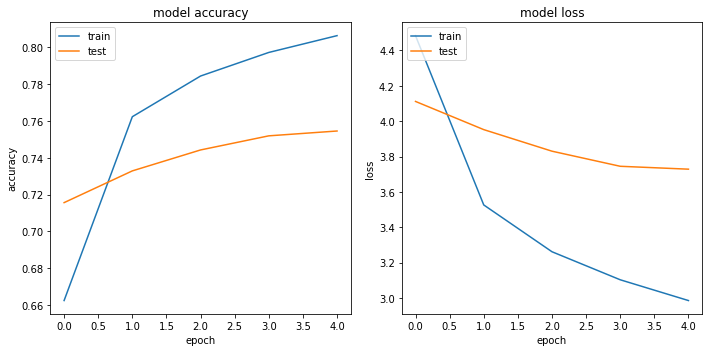

In [54]:
plotLearningCurves(historyPort)

Predict test dataframe

In [0]:
result_port = modelPort.predict(X_matrix_test_port)

**Model Spanish**

In [56]:
modelSpa = createModel( X_matrix_train_spa.shape[1], y_cat_spa.shape[1])
historySpa = modelSpa.fit(X_matrix_train_spa, y_cat_spa, epochs=5, verbose=1, validation_split=0.18)

Train on 205000 samples, validate on 45000 samples
Epoch 1/5
205000/205000 [==============================] - 249s 1ms/step - loss: 4.5640 - acc: 0.6531 - val_loss: 4.1626 - val_acc: 0.7093
Epoch 2/5
205000/205000 [==============================] - 248s 1ms/step - loss: 3.5830 - acc: 0.7570 - val_loss: 3.9947 - val_acc: 0.7287
Epoch 3/5
205000/205000 [==============================] - 248s 1ms/step - loss: 3.2599 - acc: 0.7833 - val_loss: 3.8936 - val_acc: 0.7384
Epoch 4/5
205000/205000 [==============================] - 248s 1ms/step - loss: 3.0836 - acc: 0.7970 - val_loss: 3.8401 - val_acc: 0.7419
Epoch 5/5
205000/205000 [==============================] - 248s 1ms/step - loss: 2.9489 - acc: 0.8078 - val_loss: 3.7836 - val_acc: 0.7487


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


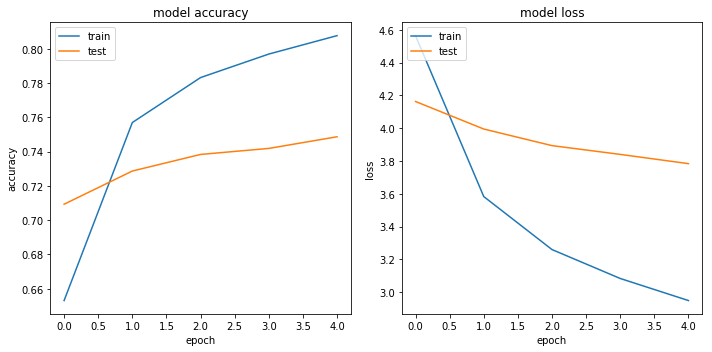

In [57]:
plotLearningCurves(historySpa)

In [0]:
result_spa = modelSpa.predict(X_matrix_test_spa)

### Making Results
  - A matriz de previsões geradas será convertida em um array de códigos e então mapeadas para os nomes da categoria. Então serão vinculadas com o id da publicação e gerado o arquivo de submissão csv utilizado no desafio. 

In [0]:
result_test_port = np.argmax(result_port, axis=1)
result_test_spa = np.argmax(result_spa, axis=1)

In [0]:
testPortuguese['category'] = result_test_port
testSpanish['category'] = result_test_spa

In [0]:
target_dict_port_inv = dict(map(reversed, target_dict_port.items()))
testPortuguese['category'] = testPortuguese['category'].map(target_dict_port_inv)

In [0]:
target_dict_spa_inv = dict(map(reversed, target_dict_spa.items()))
testSpanish['category'] = testSpanish['category'].map(target_dict_spa_inv)

In [64]:
submission = testPortuguese[['category']]
submission = submission.append(testSpanish[['category']])
submission['id'] = submission.index
submission1 = submission[['id','category']]
submission1.head()


,id,category
0,0,DIAPER_BAGS
1,1,BABY_DIAPERS
2,2,STARTERS
3,3,AUTOMOTIVE_SHOCK_ABSORBER_BUMP_STOPS
4,4,BABY_CAR_SEATS


In [0]:
submission1.to_csv('submission.csv', index=False)

In [0]:
#for dirname, _, filenames in os.walk('/content'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

Como a execução foi realizada no Google Colab é necessário fazer o download do arquivo.

In [0]:
from google.colab import files

os.chdir(r'/content')

files.download('submission.csv')